In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.cm import jet
%matplotlib inline

In [3]:
from background import NodeAndTimeAndMarkBackground, UniformTimeBackground, GaussianBackground
from clusters import NodeAndTimeAndMarkCluster, ExponentialTimeCluster, GaussianCluster, DefaultClusterFactory
from models import DirichletProcessMixtureModel, NeymanScottModel
from util import permute_to_match, onehot, compute_state_overlap

In [4]:
npr.seed(0)

In [5]:
# Make a Neyman-Scott model with gaussian marks
T = 100           # time window
M = 10            # number of nodes
data_dim = 5      # dimensionality of marks (e.g. vocab size in multinomial model)
lmbda0 = 1000      # background rate of events (across all nodes)
tau = 5           # time constant of exponential impulse responses
mu = 20           # rate of latent events
alpha = 1         # shape of gamma prior on latent event weights
beta = 1/20       # rate of gamma prior on latent event weights

# specify hyperparameters of cluster marks
niw_hypers = dict(mu0=np.zeros(data_dim),
                  lmbda=.5,
                  Psi=np.eye(data_dim),
                  nu=data_dim+1)

In [6]:
bkgd_class = NodeAndTimeAndMarkBackground
bkgd_hypers = dict(
    num_nodes=M,
    node_distribution=np.ones(M) / M,
    time_class=UniformTimeBackground,
    time_kwargs=dict(T=T),
    mark_class=GaussianBackground,
    mark_kwargs=dict(data_dim=data_dim),
    )

cluster_class = NodeAndTimeAndMarkCluster
cluster_hypers = dict(
    num_nodes=M,
    node_concentration=0.5,
    time_class=ExponentialTimeCluster,
    time_kwargs=dict(T=T, tau=tau),
    mark_class=GaussianCluster,
    mark_kwargs=niw_hypers,
    )

# Generate data without background and compare MFM and DPMM to NS

In [7]:
npr.seed(0)

true_model = NeymanScottModel(mu, alpha, beta, 1e-8, 
                              bkgd_class(**bkgd_hypers), 
                              DefaultClusterFactory(cluster_class, cluster_hypers))

# Sample from the model
sample_kwargs = dict(time_kwargs=dict(), mark_kwargs=dict())
data, parents, clusters, weights = true_model.generate(**sample_kwargs)
nodes, times, marks = data[:, 0], data[:, 1], data[:, 2:]

# Only keep the valid times
# valid = times < T
valid = np.ones_like(times, dtype=bool)
nodes = nodes[valid]
times = times[valid]
marks = marks[valid]
parents = parents[valid]

# Sort the data by time
perm = np.argsort(times)
nodes = nodes[perm]
times = times[perm]
marks = marks[perm]
parents = parents[perm]
data = np.column_stack((nodes, times, marks))

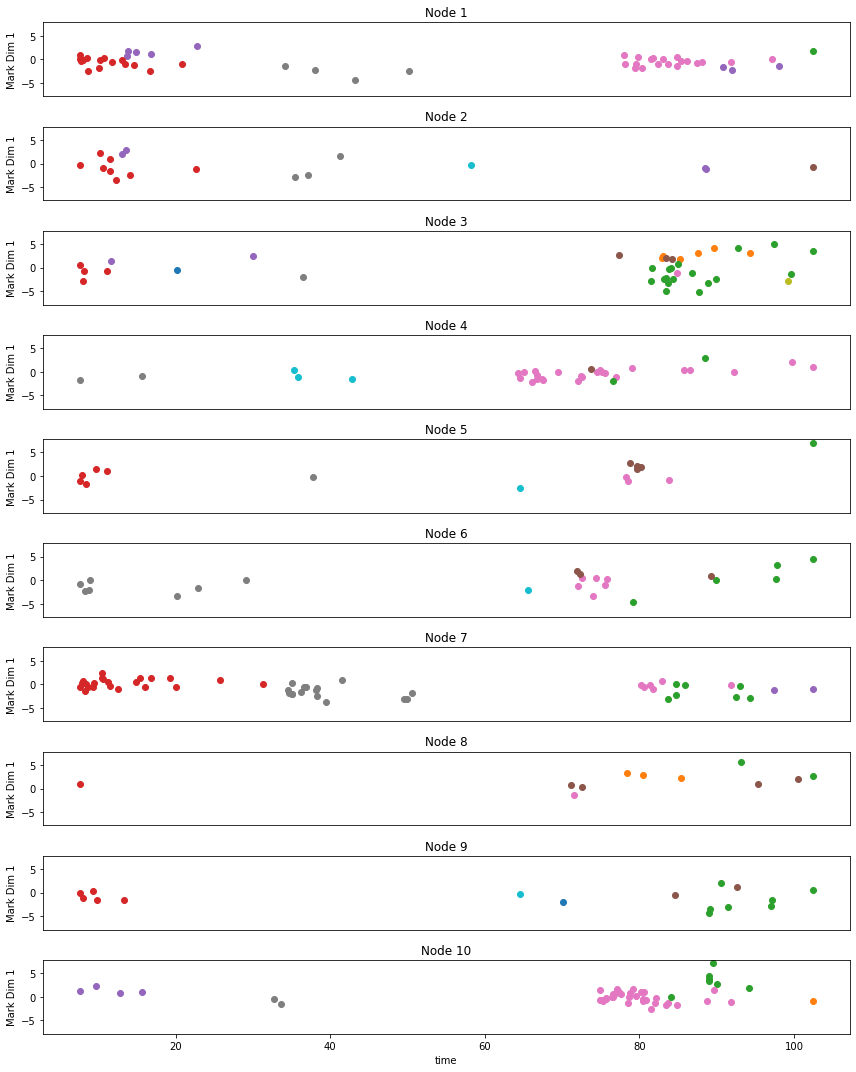

In [8]:
plt.figure(figsize=(12, 15))
ylim = 1.1 * abs(marks[:, 0]).max()
for m in range(M):
    plt.subplot(M, 1, m+1)
    for z in np.unique(parents):
        inds = np.where((parents == z) & (nodes == m))[0]
        plt.plot(times[inds], marks[inds, 0], 'o' if z >= 0 else 'ko')
    
    plt.ylabel("Mark Dim 1")
    plt.ylim(-ylim, ylim)
    if m == M-1:
        plt.xlabel("time")
    else:
        plt.xticks([])
        
    plt.title("Node {}".format(m+1))

plt.tight_layout()

In [9]:
# Fit the correct model
num_samples = 100
nsm = NeymanScottModel(mu, alpha, beta, 1e-8, 
                       bkgd_class(**bkgd_hypers), 
                       DefaultClusterFactory(cluster_class, cluster_hypers))
nsm_samples = nsm.gibbs_sample_posterior(data, num_samples=num_samples)

# Permute the sampled parents to match the true ones
nsm_parents = [permute_to_match(parents, s["parents"][perm]) for s in nsm_samples]

precomputing log_Vs



Gibbs sampling event parents


num clusters:  12
num clusters:  15
num clusters:  15
num clusters:  15
num clusters:  16
num clusters:  17
num clusters:  15
num clusters:  15
num clusters:  15
num clusters:  15
num clusters:  15
num clusters:  14
num clusters:  15
num clusters:  15
num clusters:  14
num clusters:  14
num clusters:  15
num clusters:  15
num clusters:  15
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  13
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  15
num clusters:  15
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  15
num clusters:  16
num clusters:  15
num clusters:  14
num clusters:  14
num clusters:  14
num clusters:  14
num cluste

In [10]:
# Fit the MFM with Gibbs
from models import MixtureOfFiniteMixtureModel
num_samples = 100
mfm = MixtureOfFiniteMixtureModel(mu, alpha, DefaultClusterFactory(cluster_class, cluster_hypers))
mfm_samples = mfm.gibbs_sample_posterior(data, num_samples=num_samples)

# Permute the sampled parents to match the true ones
mfm_parents = [permute_to_match(parents, s["parents"][perm]) for s in mfm_samples]

In [11]:
# Fit the DPMM with Gibbs
from models import DirichletProcessMixtureModel
num_samples = 100
dpmm = DirichletProcessMixtureModel(alpha, DefaultClusterFactory(cluster_class, cluster_hypers))
dpmm_samples = dpmm.gibbs_sample_posterior(data, num_samples=num_samples)

# Permute the sampled parents to match the true ones
dpmm_parents = [permute_to_match(parents, s["parents"][perm]) for s in dpmm_samples]

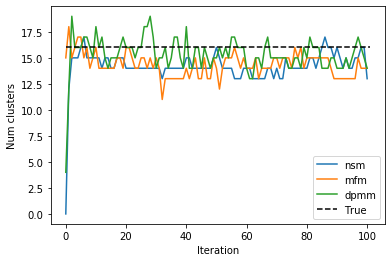

In [12]:
# Plot the number of clusters over samples
plt.figure()
plt.plot([s["num_clusters"] for s in nsm_samples], label="nsm")
plt.plot([s["num_clusters"] for s in mfm_samples], label="mfm")
plt.plot([s["num_clusters"] for s in dpmm_samples], label="dpmm")
plt.plot([0, len(mfm_samples)], [len(clusters), len(clusters)], '--k', label="True")
plt.xlabel("Iteration")
plt.ylabel("Num clusters")
plt.legend(loc="lower right")
plt.show()

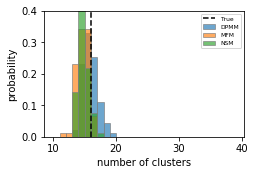

In [13]:
# Plot the number of clusters over samples
kwargs = dict(density=True, alpha=0.65, linewidth=1, edgecolor='gray')

plt.figure(figsize=(3.36, 2.25))
plt.hist([s["num_clusters"] for s in dpmm_samples[10:]], np.arange(10, 40),label="DPMM", **kwargs)
# plt.hist([s["num_clusters"] for s in dpmm_samples[10:]], np.arange(20, 40),label="dpmm", **kwargs)
plt.hist([s["num_clusters"] for s in mfm_samples[10:]], np.arange(10, 40), label="MFM", **kwargs)
plt.hist([s["num_clusters"] for s in nsm_samples[10:]], np.arange(10, 40), label="NSM", **kwargs)
plt.plot([len(clusters), len(clusters)], [0, 0.4], '--k', label="True")
plt.ylim([0, 0.4])
plt.xlabel("number of clusters")
plt.ylabel("probability")
plt.legend(loc="upper right", fontsize=6)
plt.tight_layout(pad=0.05)
# plt.savefig("synth2.pdf")